# Segmenting and Clustering Neighborhoods in Toronto

<h3>Introduction</h3>
<p>
This is an assignment for the Introduction to Artifical Intelligence course (SOFE 3720U). Within this we will be explore how to segement and cluster the neighborhoods in Toronto. 
</p>

<h3>Import Statements</h3>

In [61]:
from dotenv import load_dotenv
from dotenv import dotenv_values

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import geojson

import requests
from pandas import json_normalize

import folium

from bs4 import BeautifulSoup as bs

from sklearn.cluster import KMeans
from sklearn import preprocessing

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Libraries Imported')

Libraries Imported


<h3>Week 1 - Foursquare API</h3>
<p>
Within this section we will be using the Foursquare API to find latitude, longitude, and venues within the Toronto area.
</p>

<h4>
Setting up Foursquare API
</h4>

In [77]:
#Import the hidden values within the .env file, these values are keys used to access API
config = dotenv_values(".env")
#Assign url variable to initialize API
url = "https://api.foursquare.com/v3/places/nearby"
#Assign header which will allow us to access the website by passing through keys 
headers = {"Accept": "application/json","Authorization": config["API_KEY"]}
#Create the request statement which allows to freely use API
response = requests.request("GET", url, headers=headers)

#Initialize and define findNearbyVenues function
def findNearbyVenues(coords=None, location=None, categories=None, limit="50"):
    if(coords and categories == None):
        url = "https://api.foursquare.com/v3/places/search?ll=" + str(coords[0]) + "%2C" + str(coords[1]) + "&radius=500"  + "&limit=" + limit
    elif(coords and categories):
        url = "https://api.foursquare.com/v3/places/search?ll=" + str(coords[0]) + "%2C" + str(coords[1]) +"&categories=" + categories + "&radius=500" + "&limit=" + limit
    elif(location and categories == None):
        url = "https://api.foursquare.com/v3/places/search?" + "near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit
    elif(location and categories):
        url = "https://api.foursquare.com/v3/places/search?" + "categories=" + categories + "&near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit
    else:
        return False
    #Create the response statement from requesting from API
    response = requests.request("GET", url, headers=headers)
    #Return the result if the code was successful
    if(response.status_code == 200):
        return response.json()
    
def getVenues(names, latitudes, longitudes):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        results = findNearbyVenues(location=[lat,lng], limit="50")
        venues = results['results']

        if(len(venues) > 0):
            try:
                venues_list.append([(
                name, 
                lat, 
                lng, 
                venue['name'], 
                venue['geocodes']['main']['latitude'], 
                venue['geocodes']['main']['longitude'], venue['categories'][0]['name']) for venue in venues])
            except:
                continue

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude',  'Venue Category']
    return(nearby_venues)

def commonVenues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

print('API initialize and custom functions created')

API initialize and custom functions created


<h4>
Creating dataframe using the function created to use Foursquare API
</h4>

In [63]:
#Assign lat and long for Toronto
latitude = 43.6532 
longitude = -79.3832
#Creating police stations data frame
#Assign result variable use the custom function with the parameters below
results = findNearbyVenues(location = ["Toronto", "ON"], categories="12070", limit="50")
#Normalize the results to be able to changed
dfStations = json_normalize(results['results'], max_level=3)
#Drop unnecessary columns
dfStations.drop(dfStations.columns[[0,1,2,3,4,6,9,10,13,19]], axis=1, inplace=True)
#Display first five rows
dfStations.head()

,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,location.locality,location.neighborhood,location.postcode,location.region
0,53 Division Toronto Police Service,43.706104,-79.400647,75 Eglinton Ave W,CA,"75 Eglinton Ave W (at Duplex Ave.), Toronto ON...",Toronto,[Yonge and Eglinton],M4R 2G9,ON
1,Toronto Police Service - 13 Division,43.698433,-79.436581,1435 Eglinton Ave W,CA,"1435 Eglinton Ave W (Allen Expressway), Toront...",Toronto,[York],M6C 3Z4,ON
2,Toronto Fire Station 341,43.694398,-79.441081,555 Oakwood Ave,CA,"555 Oakwood Ave, Toronto ON M6E 2X4",Toronto,NaN,M6E 2X4,ON
3,Toronto Fire Station 131,43.726175,-79.402729,3135 Yonge St,CA,"3135 Yonge St (Wanless Ave), Toronto ON M4N 2K8",Toronto,NaN,M4N 2K8,ON
4,University of Toronto Campus Community Police,43.664817,-79.400841,21 Sussex Ave,CA,"21 Sussex Ave (btwn Huron & St. George), Toron...",Toronto,[Susex Ulster],M5S 1J6,ON


In [ ]:
<h4>
Creating dataframe using the function created to use Foursquare API
</h4>

In [64]:
#Create the map which is based on the coordinates for Toronto
mapWithMarkers = folium.Map(location=[latitude, longitude], zoom_start=10)
#Display Map
mapWithMarkers

<h3>Week 2 - Prepare your data</h3>
<p>
Within this section we will be using the provide source to create a large dataframe which contains the neccessary information for the choosen correlations
</p>

In [65]:
#Creating Neighbourhood data frame
#Add url of wikipedia page that will be scrap for data
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'
#Create a request for the data within url
temp = requests.get(url)
#Take only text from the url
data = temp.text
#Parse the html to make it easier to navigate
soup = bs(data,'html.parser')
#Find table element 
wiki = soup.find('table')
#Read and assign data from table to data frame
df = pd.read_html(str(wiki))[0]
#Display first 5 rows
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [66]:
#Drop unnecessary columns
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace=True)
df.index = range(len(df))
#Display first 5 rows
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [67]:
#Adding latitude and longitude to Neighbourhood data frame
#Reading from csv and assign to data frame
dfPostalCodes = pd.read_csv('Geospatial_Coordinates.csv')
#Renaming column to be able to merge
dfPostalCodes.rename(columns={'Postal Code':'Postcode'}, inplace=True)
#Merging the data frame
dfMerge = pd.merge(df, dfPostalCodes, on='Postcode')
#Display first 5 rows
dfMerge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


In [68]:
#Creating neighbourhood crime rate data frame
#Opening geojson file and assigning data to variable
with open('Crime_Rates.geojson') as f:
    data = geojson.load(f)
#Normalizing the data and assigning it to data frame
dfCrime=pd.json_normalize(data["features"])
#Drop unnecessary columns
dfCrime.drop(dfCrime.columns[[0,1,2,3,5,7,8,9,10,11,12,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[3,4,5,6,7,8,9,11]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[4,5,6,7,8,9,10,12]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[5,6,8,9,10,11,13]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[5,7]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[6,7,8,9,10,11,13,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[7,8,9,10,11,12,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[8,9,10]], axis=1, inplace=True)
#Renaming column to be able to merge
dfCrime.rename(columns={'properties.Neighbourhood':'Neighbourhood'}, inplace=True)
#Display first 5 rows
dfCrime.head()

,Neighbourhood,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3
1,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3
2,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0
3,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5
4,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0


In [69]:
#Creating neighbourhood population profile dataframe
#Reading from csv and assign to data frame
dfProfiles = pd.read_csv('population-profiles.csv')
#Drop unnecessary columns
dfProfiles.drop(dfProfiles.columns[[0,1,2,4,8,9,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)
#Display first 5 rows
dfProfiles.head()

,Neighbourhood,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data
0,Parkwoods,28890,4140,7660,5295,1055,9410,6105,730,"13,305"
1,Victoria Village,14550,2930,3780,2930,425,3760,2630,255,"7,410"
2,Lawrence Manor,17080,2675,4340,2635,725,5880,3730,525,"8,245"
3,Islington Avenue,37405,4440,8415,6590,1125,15135,9970,1135,"19,325"
4,Rouge,38125,6580,11740,7740,1210,9195,6765,640,"13,400"


In [70]:
#Merge all data frames to single data frame which contains all values
dfMerge2 = pd.merge(dfMerge, dfCrime, on='Neighbourhood', how='inner')
dfAll = pd.merge(dfMerge2, dfProfiles, on='Neighbourhood', how='inner')
#Replace all variations of Toronto borough to be just Toronto to achieve only 6 boroughs
dfAll["Borough"] = dfAll["Borough"].replace(["West Toronto"], "Toronto")
dfAll["Borough"] = dfAll["Borough"].replace(["East Toronto"], "Toronto")
dfAll["Borough"] = dfAll["Borough"].replace(["Central Toronto"], "Toronto")
#Display first 5 rows
dfAll.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410"
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400"
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425"
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700"
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830"


In [71]:
#Renaming column for future use
dfStations.rename(columns={'location.neighborhood':'Neighbourhood'}, inplace=True)
dfStations.rename(columns={'location.locality':'Locality'}, inplace=True)
#Display first 5 rows
dfStations.head()

,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,Locality,Neighbourhood,location.postcode,location.region
0,53 Division Toronto Police Service,43.706104,-79.400647,75 Eglinton Ave W,CA,"75 Eglinton Ave W (at Duplex Ave.), Toronto ON...",Toronto,[Yonge and Eglinton],M4R 2G9,ON
1,Toronto Police Service - 13 Division,43.698433,-79.436581,1435 Eglinton Ave W,CA,"1435 Eglinton Ave W (Allen Expressway), Toront...",Toronto,[York],M6C 3Z4,ON
2,Toronto Fire Station 341,43.694398,-79.441081,555 Oakwood Ave,CA,"555 Oakwood Ave, Toronto ON M6E 2X4",Toronto,NaN,M6E 2X4,ON
3,Toronto Fire Station 131,43.726175,-79.402729,3135 Yonge St,CA,"3135 Yonge St (Wanless Ave), Toronto ON M4N 2K8",Toronto,NaN,M4N 2K8,ON
4,University of Toronto Campus Community Police,43.664817,-79.400841,21 Sussex Ave,CA,"21 Sussex Ave (btwn Huron & St. George), Toron...",Toronto,[Susex Ulster],M5S 1J6,ON


In [72]:
torontoVenues = getVenues(names=dfAll['Neighbourhood'], latitudes=dfAll['Latitude'], longitudes=dfAll['Longitude'])
torontoVenues.head()

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Parkway Honda,43.726045,-79.316691,Car Dealership
1,Victoria Village,43.725882,-79.315572,North York Victoria Vlg Arena,43.723387,-79.315382,Stadium
2,Victoria Village,43.725882,-79.315572,Don Valley Volkswagen,43.725923,-79.315267,Car Dealership
3,Victoria Village,43.725882,-79.315572,Churrasco Portugril,43.725534,-79.312865,BBQ Joint
4,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725579,-79.313012,Pizzeria


In [73]:
torontoVenues.groupby("Neighbourhood").count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Alderwood,50,50,50,50,50,50
Bathurst Manor,50,50,50,50,50,50
Bayview Village,50,50,50,50,50,50
Cliffcrest,47,47,47,47,47,47
Dorset Park,50,50,50,50,50,50
Flemingdon Park,50,50,50,50,50,50
Forest Hill North,50,50,50,50,50,50
Henry Farm,50,50,50,50,50,50
Hillcrest Village,50,50,50,50,50,50


In [74]:
torontoVenuesFixed = pd.get_dummies(torontoVenues[['Venue Category']], prefix="", prefix_sep="")

torontoVenuesFixed['Neighbourhood'] = torontoVenues['Neighbourhood'] 

fixed_columns = [torontoVenuesFixed.columns[-1]] + list(torontoVenuesFixed.columns[:-1])
torontoVenuesFixed = torontoVenuesFixed[fixed_columns]

torontoVenuesFixed.head()

,Neighbourhood,ATM,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Arts and Crafts Store,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,Automotive Service,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Barbershop,Baseball Field,Beach,Beer Bar,Beer Store,Bicycle Store,Bingo Center,Bistro,Bookstore,Botanical Garden,Brewery,Bridal Store,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Restaurant,Butcher,"Cafes, Coffee, and Tea Houses",Café,Camera Store,Car Dealership,Car Parts and Accessories,Car Wash and Detail,Caribbean Restaurant,Carpenter,Carpet and Flooring Contractor,Caterer,Cheese Store,Chinese Restaurant,Chocolate Store,Church,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Community and Government,Computer Repair Service,Computers and Electronics Retail,Convenience Store,Cosmetics Store,Curling Ice,Dance Studio,Deli,Department Store,Dessert Shop,Diner,Dining and Drinking,Discount Store,Dive Bar,Dog Park,Doner Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Elementary School,Employment Agency,Escape Room,Event Service,Event Space,Fast Food Restaurant,Filipino Restaurant,Financial Service,Fish and Chips Shop,Flower Store,Food Court,Food and Beverage Retail,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit and Vegetable Store,Furniture and Home Store,Garden Center,Gastropub,General Contractor,Gift Store,Go Kart Track,Golf Course,Gourmet Store,Greek Restaurant,Grocery Store / Supermarket,Hair Salon,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Health and Beauty Service,Hiking Trail,Home Appliance Store,Home Improvement Service,Hotel,Housewares Store,Ice Cream Parlor,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Landmarks and Outdoors,Latin American Restaurant,Legal Service,Liquor Store,Lounge,Manufacturer,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Store,Moroccan Restaurant,Movie Theater,Museum,Music Store,Nail Salon,New American Restaurant,Noodle Restaurant,Office Supply Store,Other Great Outdoors,Painter,Park,Pet Supplies Store,Pizzeria,Playground,Plaza,Poutine Restaurant,Pub,Ramen Restaurant,Real Estate Service,Recreation Center,Restaurant,Retail,Rock Climbing Spot,Sandwich Restaurant,Sculpture Garden,Seafood Restaurant,Security and Safety,Senior Citizen Service,"Shipping, Freight, and Material Transportation Service",Shoe Store,Shopping Mall,Skating Rink,Soccer Club,Spa,Sporting Goods Retail,Sports Bar,Sports and Recreation,Stadium,Steakhouse,Storage Facility,Sushi Restaurant,Swimming Pool,Syrian Restaurant,Szechuan Restaurant,Taco Restaurant,Taiwanese Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Tire Repair Shop,Toy / Game Store,Turkish Restaurant,Urban Park,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Whisky Bar,Wine Bar,Women's Store,Zoo
0,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [75]:
torontoGrouped = torontoVenuesFixed.groupby('Neighbourhood').mean().reset_index()
torontoGrouped.head()

,Neighbourhood,ATM,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Arts and Crafts Store,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,Automotive Service,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Barbershop,Baseball Field,Beach,Beer Bar,Beer Store,Bicycle Store,Bingo Center,Bistro,Bookstore,Botanical Garden,Brewery,Bridal Store,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Restaurant,Butcher,"Cafes, Coffee, and Tea Houses",Café,Camera Store,Car Dealership,Car Parts and Accessories,Car Wash and Detail,Caribbean Restaurant,Carpenter,Carpet and Flooring Contractor,Caterer,Cheese Store,Chinese Restaurant,Chocolate Store,Church,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Community and Government,Computer Repair Service,Computers and Electronics Retail,Convenience Store,Cosmetics Store,Curling Ice,Dance Studio,Deli,Department Store,Dessert Shop,Diner,Dining and Drinking,Discount Store,Dive Bar,Dog Park,Doner Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Elementary School,Employment Agency,Escape Room,Event Service,Event Space,Fast Food Restaurant,Filipino Restaurant,Financial Service,Fish and Chips Shop,Flower Store,Food Court,Food and Beverage Retail,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit and Vegetable Store,Furniture and Home Store,Garden Center,Gastropub,General Contractor,Gift Store,Go Kart Track,Golf Course,Gourmet Store,Greek Restaurant,Grocery Store / Supermarket,Hair Salon,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Health and Beauty Service,Hiking Trail,Home Appliance Store,Home Improvement Service,Hotel,Housewares Store,Ice Cream Parlor,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Landmarks and Outdoors,Latin American Restaurant,Legal Service,Liquor Store,Lounge,Manufacturer,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Store,Moroccan Restaurant,Movie Theater,Museum,Music Store,Nail Salon,New American Restaurant,Noodle Restaurant,Office Supply Store,Other Great Outdoors,Painter,Park,Pet Supplies Store,Pizzeria,Playground,Plaza,Poutine Restaurant,Pub,Ramen Restaurant,Real Estate Service,Recreation Center,Restaurant,Retail,Rock Climbing Spot,Sandwich Restaurant,Sculpture Garden,Seafood Restaurant,Security and Safety,Senior Citizen Service,"Shipping, Freight, and Material Transportation Service",Shoe Store,Shopping Mall,Skating Rink,Soccer Club,Spa,Sporting Goods Retail,Sports Bar,Sports and Recreation,Stadium,Steakhouse,Storage Facility,Sushi Restaurant,Swimming Pool,Syrian Restaurant,Szechuan Restaurant,Taco Restaurant,Taiwanese Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Tire Repair Shop,Toy / Game Store,Turkish Restaurant,Urban Park,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Whisky Bar,Wine Bar,Women's Store,Zoo
0,Alderwood,0.0,0.02,0.0,0.04,0.0,0.0,0.000000,0.000000,0.02,0.0,0.020000,0.00,0.02,0.000000,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.000000,0.02,0.0,0.0,0.00,0.0,0.00,0.00,0.04,0.02,0.0,0.04,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.04,0.0,0.040000,0.00,0.00,0.0,0.02,0.000000,0.02,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.02,0.0,0.00,0.0,0.040000,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.04000,0.0,0.000000,0.020000,0.000000,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.040000,0.00,0.0,0.00000,0.0,0.00,0.0,0.04,0.00,0.0,0.00,0.0,0.000000,0.00,0.0,0.02,0.00,0.02,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.000000,0.0,0.02,0.00,0.0,0.02,0.0,0.040000,0.00,0.02,0.00,0.0,0.0,0.020000,0.0,0.00,0.0,0.020000,0.06,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.020000,0.000000,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.000000,0.02,0.0,0.00,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0

In [76]:
num_top_venues = 5

for hood in torontoGrouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = torontoGrouped[torontoGrouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alderwood----
                  venue  freq
0                Retail  0.06
1  Fast Food Restaurant  0.04
2           Coffee Shop  0.04
3   American Restaurant  0.04
4          Hiking Trail  0.04


----Bathurst Manor----
                  venue  freq
0                  Park  0.10
1  Fast Food Restaurant  0.06
2                 Diner  0.06
3     Convenience Store  0.06
4            Restaurant  0.04


----Bayview Village----
                  venue  freq
0                  Park  0.14
1    Chinese Restaurant  0.10
2  Fast Food Restaurant  0.08
3                  Bank  0.08
4            Playground  0.04


----Cliffcrest----
                  venue  freq
0                  Park  0.11
1            Restaurant  0.09
2                  Bank  0.09
3  Fast Food Restaurant  0.06
4       Harbor / Marina  0.06


----Dorset Park----
                         venue  freq
0         Fast Food Restaurant  0.14
1                   Restaurant  0.08
2                         Bank  0.06
3                   

In [99]:
numTopVenues = 1
indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(numTopVenues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoodsVenuesSorted = pd.DataFrame(columns=columns)
neighbourhoodsVenuesSorted['Neighbourhood'] = torontoGrouped['Neighbourhood']

for ind in np.arange(torontoGrouped.shape[0]):
    neighbourhoodsVenuesSorted.iloc[ind, 1:] = commonVenues(torontoGrouped.iloc[ind, :], numTopVenues)

neighbourhoodsVenuesSorted.head()

,Neighbourhood,1st Most Common Venue
0,Alderwood,Retail
1,Bathurst Manor,Park
2,Bayview Village,Park
3,Cliffcrest,Park
4,Dorset Park,Fast Food Restaurant


In [100]:
kclusters = 6

torontoGroupedClustering = torontoGrouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(torontoGroupedClustering)

# check cluster labels generated for each row in the dataframe
print ("cluster labels are :", kmeans.labels_[0:10])
torontoGroupedClustering.head()

cluster labels are : [1 3 3 3 0 0 5 0 3 0]


,ATM,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Arts and Crafts Store,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,Automotive Service,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Barbershop,Baseball Field,Beach,Beer Bar,Beer Store,Bicycle Store,Bingo Center,Bistro,Bookstore,Botanical Garden,Brewery,Bridal Store,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Restaurant,Butcher,"Cafes, Coffee, and Tea Houses",Café,Camera Store,Car Dealership,Car Parts and Accessories,Car Wash and Detail,Caribbean Restaurant,Carpenter,Carpet and Flooring Contractor,Caterer,Cheese Store,Chinese Restaurant,Chocolate Store,Church,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Community and Government,Computer Repair Service,Computers and Electronics Retail,Convenience Store,Cosmetics Store,Curling Ice,Dance Studio,Deli,Department Store,Dessert Shop,Diner,Dining and Drinking,Discount Store,Dive Bar,Dog Park,Doner Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Elementary School,Employment Agency,Escape Room,Event Service,Event Space,Fast Food Restaurant,Filipino Restaurant,Financial Service,Fish and Chips Shop,Flower Store,Food Court,Food and Beverage Retail,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit and Vegetable Store,Furniture and Home Store,Garden Center,Gastropub,General Contractor,Gift Store,Go Kart Track,Golf Course,Gourmet Store,Greek Restaurant,Grocery Store / Supermarket,Hair Salon,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Health and Beauty Service,Hiking Trail,Home Appliance Store,Home Improvement Service,Hotel,Housewares Store,Ice Cream Parlor,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Landmarks and Outdoors,Latin American Restaurant,Legal Service,Liquor Store,Lounge,Manufacturer,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Store,Moroccan Restaurant,Movie Theater,Museum,Music Store,Nail Salon,New American Restaurant,Noodle Restaurant,Office Supply Store,Other Great Outdoors,Painter,Park,Pet Supplies Store,Pizzeria,Playground,Plaza,Poutine Restaurant,Pub,Ramen Restaurant,Real Estate Service,Recreation Center,Restaurant,Retail,Rock Climbing Spot,Sandwich Restaurant,Sculpture Garden,Seafood Restaurant,Security and Safety,Senior Citizen Service,"Shipping, Freight, and Material Transportation Service",Shoe Store,Shopping Mall,Skating Rink,Soccer Club,Spa,Sporting Goods Retail,Sports Bar,Sports and Recreation,Stadium,Steakhouse,Storage Facility,Sushi Restaurant,Swimming Pool,Syrian Restaurant,Szechuan Restaurant,Taco Restaurant,Taiwanese Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Tire Repair Shop,Toy / Game Store,Turkish Restaurant,Urban Park,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Whisky Bar,Wine Bar,Women's Store,Zoo
0,0.0,0.02,0.0,0.04,0.0,0.0,0.000000,0.000000,0.02,0.0,0.020000,0.00,0.02,0.000000,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.000000,0.02,0.0,0.0,0.00,0.0,0.00,0.00,0.04,0.02,0.0,0.04,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.04,0.0,0.040000,0.00,0.00,0.0,0.02,0.000000,0.02,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.02,0.0,0.00,0.0,0.040000,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.04000,0.0,0.000000,0.020000,0.000000,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.040000,0.00,0.0,0.00000,0.0,0.00,0.0,0.04,0.00,0.0,0.00,0.0,0.000000,0.00,0.0,0.02,0.00,0.02,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.000000,0.0,0.02,0.00,0.0,0.02,0.0,0.040000,0.00,0.02,0.00,0.0,0.0,0.020000,0.0,0.00,0.0,0.020000,0.06,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.020000,0.000000,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.000000,0.02,0.0,0.00,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.0,

In [102]:
dfAll = dfAll.join(neighbourhoodsVenuesSorted.set_index('Neighbourhood'), on='Neighbourhood')
dfAll.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data,1st Most Common Venue
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410",Restaurant
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400",Zoo
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425",Zoo
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700",NaN
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830",Restaurant


<h3>Week 3 - Neighborhood Segmentation and Clustering</h3>
<p>
Within this section we will be using the collected data to create markers on the map and to find correlation between crime rate and population information and how they relate to a venue.
</p>

In [12]:
#Mapping all the neighbourhood left after merging with latitude and longitude
#Marker will have crime rates on click
#Looping through data frame and grabbing the required data for mapping and labeling
for name, latitude, longitude, pop, r1, r2, r3, r4, r5 ,r6 in zip(dfAll['Neighbourhood'], dfAll['Latitude'], dfAll['Longitude'], dfAll['properties.Population'], dfAll['properties.Assault_AVG'], dfAll['properties.AutoTheft_AVG'], dfAll['properties.BreakandEnter_AVG'], dfAll['properties.Homicide_AVG'], dfAll['properties.Robbery_AVG'], dfAll['properties.TheftOver_AVG']):
    label = '{}, Population = {}, Assault AVG = {}, Auto Theft AVG = {}, Break and Enter AVG = {}, Homicide AVG = {}, Robbery AVG = {}, Theft Over AVG = {}'.format(name, pop, r1, r2, r3, r4, r5, r6)
    label = folium.Popup(label, parse_html=True, max_width=300, min_width=300)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(mapWithMarkers)
#Display map
mapWithMarkers

In [13]:
#Mapping the neighbourboods based on the 6 boroughs within Toronto
k=6
#Copy data frame with all data
toronto_clustering = dfAll
#Use kmeans to cluster the data based on borough
kmeans = KMeans(n_clusters = k).fit(pd.get_dummies(toronto_clustering[["Borough"]]))
#Insert new column with the values clustered
dfAll.insert(0, 'Cluster Labels', kmeans.labels_)
#Fix column headings to reduce errors and increase usability
dfAll.columns = dfAll.columns.str.replace(' ', '_')
#Display first 5 rows
dfAll.head()

,Cluster_Labels,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total_-_Highest_certificate,_diploma_or_degree_for_the_population_aged_15_years_and_over_in_private_households_-_25%_sample_data",__No_certificate_diploma_or_degree,__Secondary_(high)_school_diploma_or_equivalency_certificate,"____College,_CEGEP_or_other_non-university_certificate_or_diploma",____University_certificate_or_diploma_below_bachelor_level,"____University_certificate,_diploma_or_degree_at_bachelor_level_or_above",______Bachelor's_degree,______University_certificate_or_diploma_above_bachelor_level,Total_-_Household_total_income_groups_in_2015_for_private_households_-_100%_data
0,1,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410"
1,2,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400"
2,2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425"
3,2,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700"
4,1,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830"


In [14]:
#Create the map which will have markers for the clustered data
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
#Adding colours to be assigned to each borough
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []

#Marker will have cluster number, borough, neighbourhood, and robbery average
#Looping through data frame and grabbing the required data for mapping and labeling
for lat, lon, neighbourhood, cluster, avg, borough, pop in zip(dfAll['Latitude'], dfAll['Longitude'], dfAll['Neighbourhood'], dfAll['Cluster_Labels'], dfAll['properties.Robbery_AVG'], dfAll["Borough"], dfAll["properties.Population"]):
    label = folium.Popup('Cluster:' + str(cluster) +"\n" + 'Borough:' + str(borough) +"\n" + "neighbourhood:" + str(neighbourhood) +"\n" + "Robbery avg:" + str(avg) + "\n"  + "Population:" + str(pop), parse_html=True, max_width=300, max_height=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
#Display map     
map_clusters

In [15]:
#This section to find the correlation between population sum and robbery average within the borough
dfCluster1 = dfAll.loc[dfAll["Cluster_Labels"] == 0]
dfC1CrimeAvg = dfCluster1[["properties.Robbery_AVG"]].mean()
dfC1PopSum = dfCluster1[["properties.Population"]].sum()
print("Scarborough:")
print("Robbery Avg=")
print(dfC1CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC1PopSum)
print("\n")

dfCluster2 = dfAll.loc[dfAll["Cluster_Labels"] == 1]
dfC2CrimeAvg = dfCluster2[["properties.Robbery_AVG"]].mean()
dfC2PopSum = dfCluster2[["properties.Population"]].sum()
print("North York")
print("Robbery Avg=")
print(dfC2CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC2PopSum)
print("\n")

dfCluster3 = dfAll.loc[dfAll["Cluster_Labels"] == 2]
dfC3CrimeAvg = dfCluster3[["properties.Robbery_AVG"]].mean()
dfC3PopSum = dfCluster3[["properties.Population"]].sum()
print("Etobicoke")
print("Robbery Avg=")
print(dfC3CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC3PopSum)
print("\n")

dfCluster4 = dfAll.loc[dfAll["Cluster_Labels"] == 3]
dfC4CrimeAvg = dfCluster4[["properties.Homicide_AVG"]].mean()
dfC4PopSum = dfCluster4[["properties.Population"]].sum()
print("Toronto")
print("Robbery Avg=")
print(dfC4CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC4PopSum)
print("\n")


dfCluster5 = dfAll.loc[dfAll["Cluster_Labels"] == 4]
dfC5CrimeAvg = dfCluster5[["properties.Robbery_AVG"]].mean()
dfC5PopSum = dfCluster5[["properties.Population"]].sum()
print("York")
print("Robbery Avg=")
print(dfC5CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC5PopSum)
print("\n")

dfCluster6 = dfAll.loc[dfAll["Cluster_Labels"] == 5]
dfC6CrimeAvg = dfCluster6[["properties.Robbery_AVG"]].mean()
dfC6PopSum = dfCluster6[["properties.Population"]].sum()
print("East York")
print("Robbery Avg=")
print(dfC6CrimeAvg)
print("Total Population in Neighbourhood=")
print(dfC6PopSum)
print("\n")

Scarborough:
Robbery Avg=
properties.Robbery_AVG    15.425
dtype: float64
Total Population in Neighbourhood=
properties.Population    64906
dtype: int64


North York
Robbery Avg=
properties.Robbery_AVG    15.1625
dtype: float64
Total Population in Neighbourhood=
properties.Population    138721
dtype: int64


Etobicoke
Robbery Avg=
properties.Robbery_AVG    34.757143
dtype: float64
Total Population in Neighbourhood=
properties.Population    339876
dtype: int64


Toronto
Robbery Avg=
properties.Homicide_AVG    0.175
dtype: float64
Total Population in Neighbourhood=
properties.Population    44155
dtype: int64


York
Robbery Avg=
properties.Robbery_AVG    23.433333
dtype: float64
Total Population in Neighbourhood=
properties.Population    45950
dtype: int64


East York
Robbery Avg=
properties.Robbery_AVG    11.0
dtype: float64
Total Population in Neighbourhood=
properties.Population    21108
dtype: int64




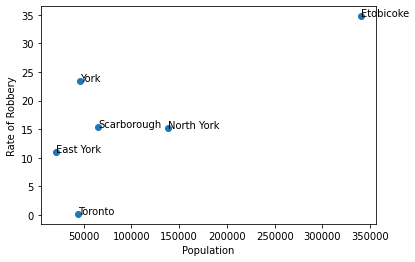

In [16]:
#Assign the x, y, and labe;s for the coordinates based on how they will be mapped
x=np.array([dfC3PopSum, dfC4PopSum, dfC5PopSum, dfC1PopSum, dfC6PopSum, dfC2PopSum])
y=np.array([dfC3CrimeAvg, dfC4CrimeAvg, dfC5CrimeAvg, dfC1CrimeAvg, dfC6CrimeAvg, dfC2CrimeAvg])
label=["Etobicoke", "Toronto", "York", "Scarborough", "East York", "North York"]
#Scatter the data
fig, ax = plt.subplots()
ax.scatter(x, y)
#Adding labels to boroughs
for i, txt in enumerate(label):
    ax.annotate(txt, (x[i], y[i]))
#Labeling x and y axis
plt.ylabel("Rate of Robbery")
plt.xlabel("Population")
#Display plot
plt.show()

In [17]:
#Create the map which will have markers for the clustered data and the police stations
mapClusterWithStations = folium.Map(location=[latitude, longitude], zoom_start=10)
#Adding colours to be assigned to each borough
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Marker will have cluster number, borough, neighbourhood, and robbery average
#Looping through data frame and grabbing the required data for mapping and labeling
markers_colors = []
for lat, lon, neighbourhood, cluster, avg, pop, borough in zip(dfAll['Latitude'], dfAll['Longitude'], dfAll['Neighbourhood'], dfAll['Cluster_Labels'], dfAll['properties.Robbery_AVG'], dfAll["properties.Population"], dfAll["Borough"]):
    label = folium.Popup('Cluster:' + str(cluster) +"\n" + 'Borough:' + str(borough) +"\n" + "neighbourhood:" + str(neighbourhood) +"\n" + "Robbery avg:" + str(avg) + "\n"  + "Population:" + str(pop), parse_html=True, max_width=300, max_height=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapClusterWithStations)
    
#Adding markers for police stations 
#Will display the stations' name on click
for name, latitude, longitude in zip(dfStations['name'], dfStations['geocodes.main.latitude'], dfStations['geocodes.main.longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(mapClusterWithStations)
       
mapClusterWithStations